#  CE-40710: Deep Learning
#  Fall 2023 - Dr. Beigy 
## Hamidreza Amirzadeh
### 401206999
Note : We used a sigmoid activation for the last layer of decoder and alos we used binary cross entropy instead of MSE in order to increase the performance

## Homework 5: VAE


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

---

In [ ]:
CUDA = True
BATCH_SIZE = 128
LEARNING_RATE = 0.01

---

In [ ]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

---

In [ ]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

In [ ]:
# Define Train loader
train_tensors = original_train_dataset.data.float() / 255
test_tensors = original_test_dataset.data.float() / 255

# Define Datasets
train_dataset = torch.utils.data.TensorDataset(train_tensors, original_train_dataset.targets)
test_dataset = torch.utils.data.TensorDataset(test_tensors, original_test_dataset.targets)

# Define dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

---

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims, dropout_rate=0.2):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.z_dim = z_dim
        
        ########################## TODO ##########################
        # self.input_dropout must be a dropout module with p=dropout_rate
        self.input_dropout = nn.Dropout(p = dropout_rate)
        ######################## END TODO ########################
        
        # Encoder part
        encoder_layers = []
        ########################## TODO ##########################
        # Define encoder layers and add them to `encoder_layers`
        # Use ReLU for activation functions
        encoder_layers.append(nn.Linear(input_dim, encoder_dims[0]))
        encoder_layers.append(nn.ReLU())
        encoder_layers.append(nn.Linear(encoder_dims[0], encoder_dims[1]))
        encoder_layers.append(nn.ReLU())
        ######################## END TODO ########################
        self.encoder = nn.Sequential(*encoder_layers)
        
        encoder_last_dim = ([input_dim] + encoder_dims)[-1]
        
        # mu and log_var
        ########################## TODO ##########################
        # Define mu and log_var layers
        # They do not need any activation function
        self.mu_layer = nn.Linear(encoder_dims[1], z_dim)
        self.log_var_layer = nn.Linear(encoder_dims[1], z_dim)
        ######################## END TODO ########################
        
        # Decoder part
        decoder_layers = []
        ########################## TODO ##########################
        # Define decoder layers and add them to `decoder_layers`
        # Use ReLU for activation functions
        # Last layer does not need any activation function
        decoder_layers.append(nn.Linear(z_dim, decoder_dims[0]))
        decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(decoder_dims[0], decoder_dims[1]))
        decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(decoder_dims[1], input_dim))
        decoder_layers.append(nn.Sigmoid())
        ######################## END TODO ########################
        self.decoder = nn.Sequential(*decoder_layers)

    @staticmethod
    def _sampling(mu, log_var):
        """
        This function is in charge of reparametrization trick
        """
        ########################## TODO ##########################
        # Generate a random z from N(mu=mu, var=e^log_var)
        std = torch.exp(0.5*log_var)
        eps = torch.rand_like(std)
        z = mu + eps*std
        ######################## END TODO ########################
        return z

    def forward(self, data):
        x = data.get("X")
        ########################## TODO ##########################
        # Complete the flow
        # x > dropout > encoder > mu, log_var > z > decoder > output
        h = self.encoder(x.view(-1,self.input_dim))
        mu = self.mu_layer(h)
        log_var = self.log_var_layer(h)
        z = self._sampling(mu, log_var)
        output = self.decoder(z)
        ######################## END TODO ########################
        return {"X": output, "mu": mu, "log_var": log_var, "z": z}
    
    def loss(self, data, output):
      x = data.get("X")
      recon_x = output.get("X")
      mu = output.get("mu")
      log_var = output.get("log_var")
      ########################## TODO ##########################
      # Calculate MSE and KLD
      BCE = F.binary_cross_entropy(recon_x, x.view(-1, self.input_dim), reduction='sum')
      KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
      # loss = nn.MSELoss()
      # MSE = loss(x.view(-1,self.input_dim), recon_x)
      
      ######################## END TODO ########################
      return {"final": BCE+KLD, "KLD": KLD, "MSE": BCE}

---

In [ ]:
def train(model, data_loader, optimizer, epoch="?", print_every=100, verbose=True):
    """
    This function trains a `model` given a `data_loader` by `optimizer`
    """
    model.train()

    train_loss = 0
    device = torch.device('cuda') if torch.cuda.is_available() else torch.decice('cpu')

    for batch_idx, batch_data in enumerate(data_loader):
        supervised_training = len(batch_data) == 2

        if supervised_training:
            # Labeled data
            data = {"X": batch_data[0],
                    "Y": batch_data[1]}
        else:
            # Unlabeled data
            data = {"X": batch_data[0]}

        # Flatten data
        ########################## TODO ##########################
        # Use `flatten` function from pytorch
        data['X'] = torch.flatten(data['X'])
        ######################## END TODO ########################

        if CUDA:
            ########################## TODO ##########################
            # Send tensors in data to GPU
            if supervised_training:
              data['X'] = data['X'].to(device)
              data['Y'] = data['Y'].to(device)
            else:
              data['X'] = data['X'].to(device)
            ######################## END TODO ########################


        ########################## TODO ##########################
        # Think about this part
        ######################## END TODO ########################
        optimizer.zero_grad()

        output = model(data)
        loss = model.loss(data, output)
        final_loss = loss["final"]
        train_loss += final_loss.item()

        final_loss.backward()
        optimizer.step()
        ########################## TODO ##########################
        # Thinking ends here
        ######################## END TODO ########################

        if batch_idx % print_every == 0 and verbose:
            print('Train | Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data["X"]), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), final_loss.item() / len(data["X"])))

    train_loss /= len(data_loader.dataset)
    if verbose:
        print('====> Train | Epoch: {} \t | \t Average loss: {:.4f}'.format(epoch, train_loss,))

    return {"final": train_loss}

In [ ]:
def test(model, data_loader, verbose=True):
    """
    This function tests a `model` on a `data_loader`
    """
    model.eval()

    test_loss = 0
    device = torch.device('cuda') if torch.cuda.is_available() else torch.decice('cpu')

    labels, y_preds = None, None
    with torch.no_grad():
        for batch_data  in data_loader:
            supervised = len(batch_data) == 2

            if supervised:
                # Labeled data
                data = {"X": batch_data[0],
                        "Y": batch_data[1]}
            else:
                # Unlabeled data
                data = {"X": batch_data[0]}

            #  Flatten data
            ########################## TODO ##########################
            # Use `flatten` function from pytorch
            data['X'] = torch.flatten(data['X'])
            ######################## END TODO ########################

            if CUDA:
                ########################## TODO ##########################
                # Send tensors in data to GPU
                if supervised:
                  data['X'] = data['X'].to(device)
                  data['Y'] = data['Y'].to(device)
                else:
                  data['X'] = data['X'].to(device)
                ######################## END TODO ########################

            output = model(data)
            loss = model.loss(data, output)
            final_loss = loss["final"]
            test_loss += final_loss.item()

            # Storing y_true and y_pred if learning is supervised
            supervised = supervised and "Y" in output
            if supervised:
                y_pred = np.argmax(output["Y"].detach().cpu().numpy(), axis=1)
                y_true = data["Y"].cpu().numpy()
                if labels is None:
                    labels = y_true
                    y_preds = y_pred
                else:
                    labels = np.concatenate((labels, y_true), axis=None)
                    y_preds = np.concatenate((y_preds, y_pred), axis=None)

    test_loss /= len(data_loader.dataset)

    if supervised:
        accuracy = accuracy_score(labels, y_preds)
        if verbose:
            print('====> Test  | model loss: {:.4f}'.format(test_loss))
            print('            |   accuracy: {:.4f}'.format(100 * accuracy))
            print(classification_report(labels, y_preds))
        return {"final": test_loss, "accuracy": accuracy}
    else:
        if verbose:
            print('====> Test  | model loss: {:.4f}'.format(test_loss))
        return {"final": test_loss}

In [ ]:
def run(model, parameters, n_epoch, train_loader, test_loader,
        end_function=lambda model:None):
    """
    This function will optimize `parameters` of `model` for `n_epoch` epochs
    on `train_loader` dataset and validate it on `test_loader`.
    At the end of each epoch, `end_function` will be called on `model`.
    """
    if CUDA:
        model.cuda()

    ########################## TODO ##########################
    # Initialize a new Adam optimizer.
    # Set learning rate to LEARNING_RATE / BATCH_SIZE (why?)
    learning_rate = LEARNING_RATE / BATCH_SIZE
    optimizer = torch.optim.Adam(parameters, lr=learning_rate)
    ######################## END TODO ########################

    for epoch in range(1, n_epoch + 1):
        train_loss = train(model, train_loader, optimizer, epoch)
        test_loss = test(model, test_loader)
        end_function(model)

In [ ]:
def show(image_batch, rows=1):
    # Set Plot dimensions
    cols = np.ceil(image_batch.shape[0] / rows)
    plt.rcParams['figure.figsize'] = (0.0 + cols, 0.0 + rows) # set default size of plots
    
    for i in range(image_batch.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
        plt.axis('off')
    plt.show()

---

In [ ]:
vae = VAE(784, encoder_dims=[512, 128], z_dim=32, decoder_dims=[128, 512])
print(vae)

# Output might be like:
# VAE(
#   (input_dropout): Dropout(p=0.2)
#   (encoder): Sequential(
#     (0): Linear(in_features=784, out_features=512, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=512, out_features=128, bias=True)
#     (3): ReLU()
#   )
#   (mu_layer): Linear(in_features=128, out_features=32, bias=True)
#   (log_var_layer): Linear(in_features=128, out_features=32, bias=True)
#   (decoder): Sequential(
#     (0): Linear(in_features=32, out_features=128, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=128, out_features=512, bias=True)
#     (3): ReLU()
#     (4): Linear(in_features=512, out_features=784, bias=True)
#   )
# )

VAE(
  (input_dropout): Dropout(p=0.2, inplace=False)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
  )
  (mu_layer): Linear(in_features=128, out_features=32, bias=True)
  (log_var_layer): Linear(in_features=128, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [ ]:
def show_vae(vae):
    # Select 10 random inputs
    data_loader = train_loader
    indices = torch.randint(data_loader.dataset.tensors[0].shape[0], (10,))
    input_img = data_loader.dataset.tensors[0][indices]
    print("Inputs:")
    show(input_img.numpy())
    # Calculate reconstructions
    input_img = input_img.flatten(start_dim=1)
    if CUDA:
        input_img = input_img.cuda()
    recons_img = vae({"X": input_img})["X"]
    recons_img = recons_img.detach().cpu().view(-1, 28, 28).numpy()
    print("Reconstructions:")
    show(recons_img)
    # Generate images
    z = torch.randn(10, vae.z_dim)
    if CUDA:
        z = z.cuda()
    generated_img = vae.decoder(z)
    generated_img = generated_img.detach().cpu().view(-1, 28, 28).numpy()
    print("Generated Images:")
    show(generated_img)

Train | Epoch: 1 [0/60000 (0%)]	Loss: 0.696437
Train | Epoch: 1 [10035200/60000 (21%)]	Loss: 0.305424
Train | Epoch: 1 [20070400/60000 (43%)]	Loss: 0.261975
Train | Epoch: 1 [30105600/60000 (64%)]	Loss: 0.266043
Train | Epoch: 1 [40140800/60000 (85%)]	Loss: 0.252470
====> Train | Epoch: 1 	 | 	 Average loss: 249.8136
====> Test  | model loss: 191.1013
Inputs:


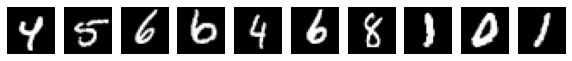

Reconstructions:


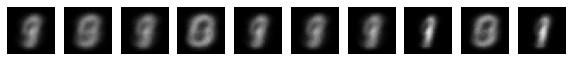

Generated Images:


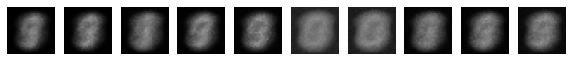

Train | Epoch: 2 [0/60000 (0%)]	Loss: 0.240971
Train | Epoch: 2 [10035200/60000 (21%)]	Loss: 0.238895
Train | Epoch: 2 [20070400/60000 (43%)]	Loss: 0.234977
Train | Epoch: 2 [30105600/60000 (64%)]	Loss: 0.216699
Train | Epoch: 2 [40140800/60000 (85%)]	Loss: 0.211753
====> Train | Epoch: 2 	 | 	 Average loss: 174.7420
====> Test  | model loss: 157.4714
Inputs:


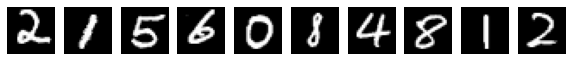

Reconstructions:


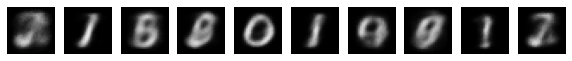

Generated Images:


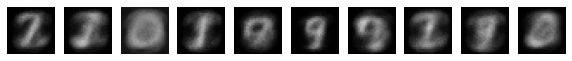

Train | Epoch: 3 [0/60000 (0%)]	Loss: 0.204416
Train | Epoch: 3 [10035200/60000 (21%)]	Loss: 0.198808
Train | Epoch: 3 [20070400/60000 (43%)]	Loss: 0.194348
Train | Epoch: 3 [30105600/60000 (64%)]	Loss: 0.180347
Train | Epoch: 3 [40140800/60000 (85%)]	Loss: 0.183483
====> Train | Epoch: 3 	 | 	 Average loss: 148.5522
====> Test  | model loss: 140.9717
Inputs:


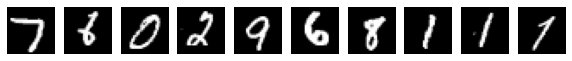

Reconstructions:


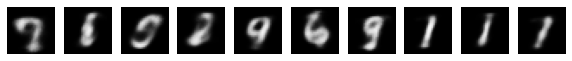

Generated Images:


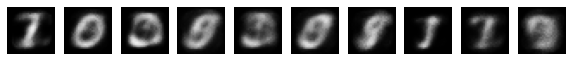

Train | Epoch: 4 [0/60000 (0%)]	Loss: 0.186707
Train | Epoch: 4 [10035200/60000 (21%)]	Loss: 0.169778
Train | Epoch: 4 [20070400/60000 (43%)]	Loss: 0.167951
Train | Epoch: 4 [30105600/60000 (64%)]	Loss: 0.167988
Train | Epoch: 4 [40140800/60000 (85%)]	Loss: 0.170044
====> Train | Epoch: 4 	 | 	 Average loss: 137.1774
====> Test  | model loss: 131.3685
Inputs:


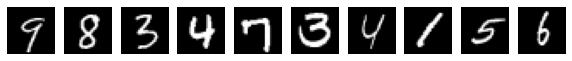

Reconstructions:


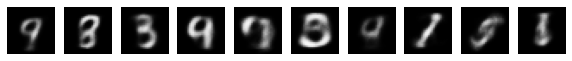

Generated Images:


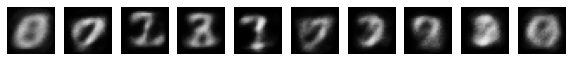

Train | Epoch: 5 [0/60000 (0%)]	Loss: 0.166410
Train | Epoch: 5 [10035200/60000 (21%)]	Loss: 0.163347
Train | Epoch: 5 [20070400/60000 (43%)]	Loss: 0.172483
Train | Epoch: 5 [30105600/60000 (64%)]	Loss: 0.156713
Train | Epoch: 5 [40140800/60000 (85%)]	Loss: 0.162108
====> Train | Epoch: 5 	 | 	 Average loss: 129.6315
====> Test  | model loss: 125.8624
Inputs:


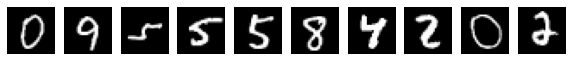

Reconstructions:


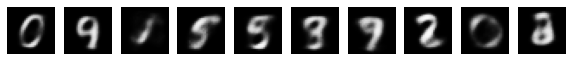

Generated Images:


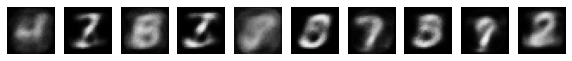

Train | Epoch: 6 [0/60000 (0%)]	Loss: 0.172079
Train | Epoch: 6 [10035200/60000 (21%)]	Loss: 0.164682
Train | Epoch: 6 [20070400/60000 (43%)]	Loss: 0.164651
Train | Epoch: 6 [30105600/60000 (64%)]	Loss: 0.160882
Train | Epoch: 6 [40140800/60000 (85%)]	Loss: 0.156008
====> Train | Epoch: 6 	 | 	 Average loss: 124.8289
====> Test  | model loss: 121.8898
Inputs:


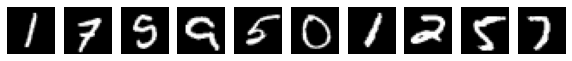

Reconstructions:


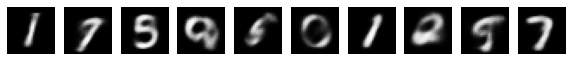

Generated Images:


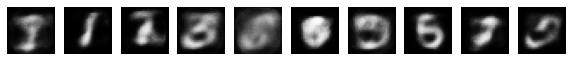

Train | Epoch: 7 [0/60000 (0%)]	Loss: 0.154698
Train | Epoch: 7 [10035200/60000 (21%)]	Loss: 0.162737
Train | Epoch: 7 [20070400/60000 (43%)]	Loss: 0.157955
Train | Epoch: 7 [30105600/60000 (64%)]	Loss: 0.158446
Train | Epoch: 7 [40140800/60000 (85%)]	Loss: 0.156352
====> Train | Epoch: 7 	 | 	 Average loss: 121.2848
====> Test  | model loss: 118.7103
Inputs:


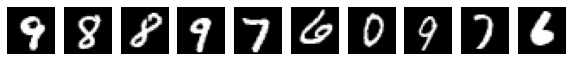

Reconstructions:


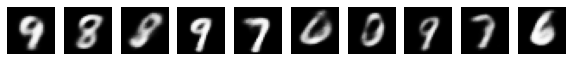

Generated Images:


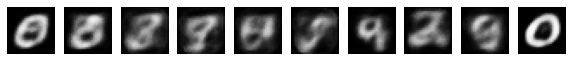

Train | Epoch: 8 [0/60000 (0%)]	Loss: 0.152052
Train | Epoch: 8 [10035200/60000 (21%)]	Loss: 0.147140
Train | Epoch: 8 [20070400/60000 (43%)]	Loss: 0.146372
Train | Epoch: 8 [30105600/60000 (64%)]	Loss: 0.146237
Train | Epoch: 8 [40140800/60000 (85%)]	Loss: 0.154144
====> Train | Epoch: 8 	 | 	 Average loss: 118.3415
====> Test  | model loss: 115.9456
Inputs:


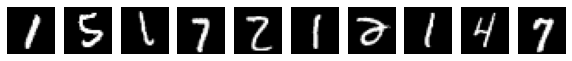

Reconstructions:


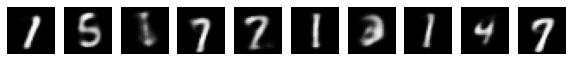

Generated Images:


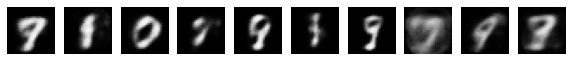

Train | Epoch: 9 [0/60000 (0%)]	Loss: 0.146192
Train | Epoch: 9 [10035200/60000 (21%)]	Loss: 0.146735
Train | Epoch: 9 [20070400/60000 (43%)]	Loss: 0.148650
Train | Epoch: 9 [30105600/60000 (64%)]	Loss: 0.147832
Train | Epoch: 9 [40140800/60000 (85%)]	Loss: 0.144676
====> Train | Epoch: 9 	 | 	 Average loss: 115.5501
====> Test  | model loss: 112.9953
Inputs:


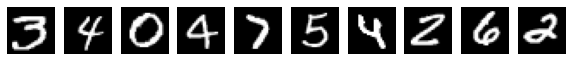

Reconstructions:


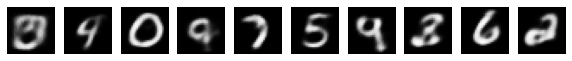

Generated Images:


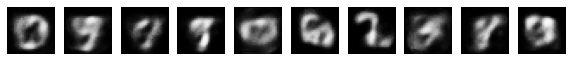

Train | Epoch: 10 [0/60000 (0%)]	Loss: 0.144620
Train | Epoch: 10 [10035200/60000 (21%)]	Loss: 0.150233
Train | Epoch: 10 [20070400/60000 (43%)]	Loss: 0.143855
Train | Epoch: 10 [30105600/60000 (64%)]	Loss: 0.138545
Train | Epoch: 10 [40140800/60000 (85%)]	Loss: 0.143697
====> Train | Epoch: 10 	 | 	 Average loss: 112.7782
====> Test  | model loss: 110.4536
Inputs:


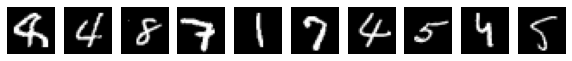

Reconstructions:


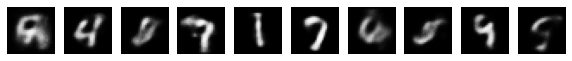

Generated Images:


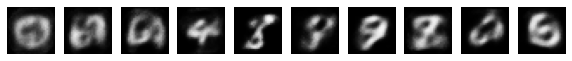

Train | Epoch: 11 [0/60000 (0%)]	Loss: 0.141543
Train | Epoch: 11 [10035200/60000 (21%)]	Loss: 0.143317
Train | Epoch: 11 [20070400/60000 (43%)]	Loss: 0.140304
Train | Epoch: 11 [30105600/60000 (64%)]	Loss: 0.145786
Train | Epoch: 11 [40140800/60000 (85%)]	Loss: 0.146806
====> Train | Epoch: 11 	 | 	 Average loss: 110.4010
====> Test  | model loss: 108.2089
Inputs:


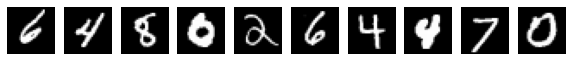

Reconstructions:


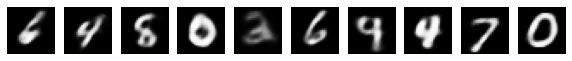

Generated Images:


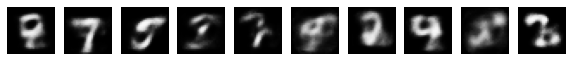

Train | Epoch: 12 [0/60000 (0%)]	Loss: 0.133661
Train | Epoch: 12 [10035200/60000 (21%)]	Loss: 0.138517
Train | Epoch: 12 [20070400/60000 (43%)]	Loss: 0.140505
Train | Epoch: 12 [30105600/60000 (64%)]	Loss: 0.135662
Train | Epoch: 12 [40140800/60000 (85%)]	Loss: 0.133257
====> Train | Epoch: 12 	 | 	 Average loss: 108.5037
====> Test  | model loss: 106.5060
Inputs:


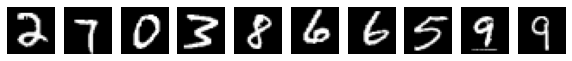

Reconstructions:


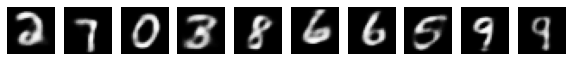

Generated Images:


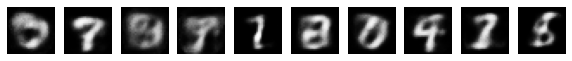

Train | Epoch: 13 [0/60000 (0%)]	Loss: 0.142554
Train | Epoch: 13 [10035200/60000 (21%)]	Loss: 0.141103
Train | Epoch: 13 [20070400/60000 (43%)]	Loss: 0.140332
Train | Epoch: 13 [30105600/60000 (64%)]	Loss: 0.135204
Train | Epoch: 13 [40140800/60000 (85%)]	Loss: 0.136334
====> Train | Epoch: 13 	 | 	 Average loss: 107.0321
====> Test  | model loss: 105.1999
Inputs:


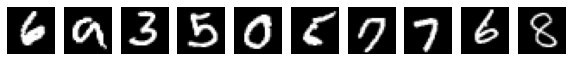

Reconstructions:


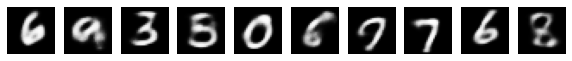

Generated Images:


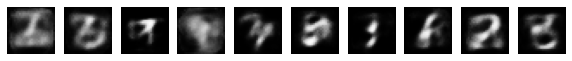

Train | Epoch: 14 [0/60000 (0%)]	Loss: 0.136422
Train | Epoch: 14 [10035200/60000 (21%)]	Loss: 0.135744
Train | Epoch: 14 [20070400/60000 (43%)]	Loss: 0.138756
Train | Epoch: 14 [30105600/60000 (64%)]	Loss: 0.132791
Train | Epoch: 14 [40140800/60000 (85%)]	Loss: 0.128557
====> Train | Epoch: 14 	 | 	 Average loss: 105.6145
====> Test  | model loss: 103.8636
Inputs:


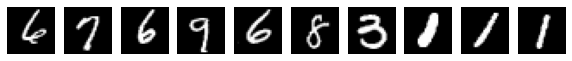

Reconstructions:


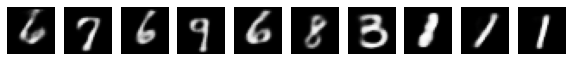

Generated Images:


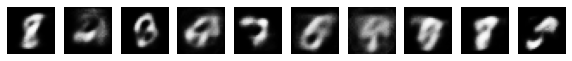

Train | Epoch: 15 [0/60000 (0%)]	Loss: 0.130496
Train | Epoch: 15 [10035200/60000 (21%)]	Loss: 0.137110
Train | Epoch: 15 [20070400/60000 (43%)]	Loss: 0.130522
Train | Epoch: 15 [30105600/60000 (64%)]	Loss: 0.133397
Train | Epoch: 15 [40140800/60000 (85%)]	Loss: 0.135105
====> Train | Epoch: 15 	 | 	 Average loss: 104.4177
====> Test  | model loss: 102.7336
Inputs:


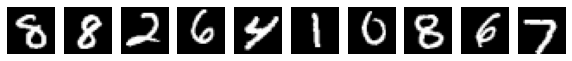

Reconstructions:


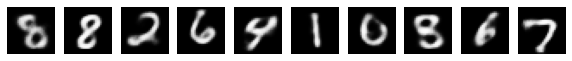

Generated Images:


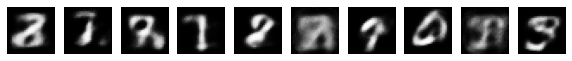

Train | Epoch: 16 [0/60000 (0%)]	Loss: 0.125170
Train | Epoch: 16 [10035200/60000 (21%)]	Loss: 0.129672
Train | Epoch: 16 [20070400/60000 (43%)]	Loss: 0.133612
Train | Epoch: 16 [30105600/60000 (64%)]	Loss: 0.135462
Train | Epoch: 16 [40140800/60000 (85%)]	Loss: 0.124183
====> Train | Epoch: 16 	 | 	 Average loss: 103.3842
====> Test  | model loss: 101.8019
Inputs:


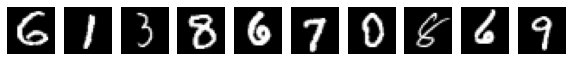

Reconstructions:


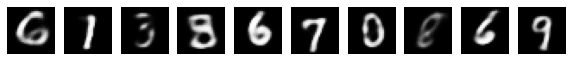

Generated Images:


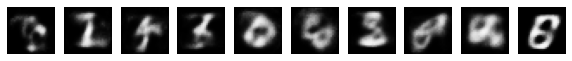

Train | Epoch: 17 [0/60000 (0%)]	Loss: 0.126452
Train | Epoch: 17 [10035200/60000 (21%)]	Loss: 0.128527
Train | Epoch: 17 [20070400/60000 (43%)]	Loss: 0.137484
Train | Epoch: 17 [30105600/60000 (64%)]	Loss: 0.132379
Train | Epoch: 17 [40140800/60000 (85%)]	Loss: 0.135234
====> Train | Epoch: 17 	 | 	 Average loss: 102.4462
====> Test  | model loss: 100.9279
Inputs:


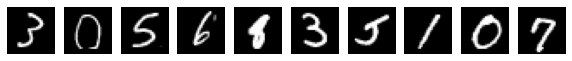

Reconstructions:


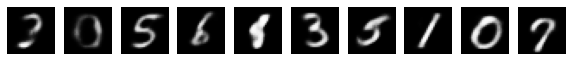

Generated Images:


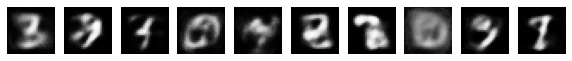

Train | Epoch: 18 [0/60000 (0%)]	Loss: 0.125785
Train | Epoch: 18 [10035200/60000 (21%)]	Loss: 0.126114
Train | Epoch: 18 [20070400/60000 (43%)]	Loss: 0.125855
Train | Epoch: 18 [30105600/60000 (64%)]	Loss: 0.130971
Train | Epoch: 18 [40140800/60000 (85%)]	Loss: 0.129702
====> Train | Epoch: 18 	 | 	 Average loss: 101.5184
====> Test  | model loss: 100.1087
Inputs:


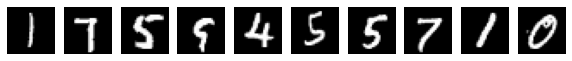

Reconstructions:


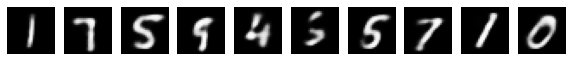

Generated Images:


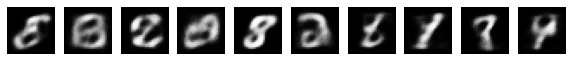

Train | Epoch: 19 [0/60000 (0%)]	Loss: 0.128888
Train | Epoch: 19 [10035200/60000 (21%)]	Loss: 0.126158
Train | Epoch: 19 [20070400/60000 (43%)]	Loss: 0.124084
Train | Epoch: 19 [30105600/60000 (64%)]	Loss: 0.129207
Train | Epoch: 19 [40140800/60000 (85%)]	Loss: 0.129905
====> Train | Epoch: 19 	 | 	 Average loss: 100.6428
====> Test  | model loss: 99.1060
Inputs:


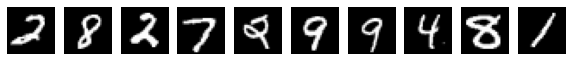

Reconstructions:


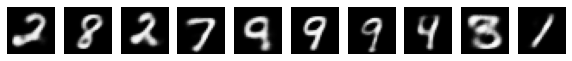

Generated Images:


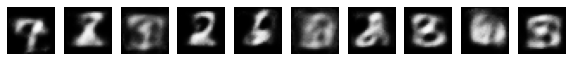

Train | Epoch: 20 [0/60000 (0%)]	Loss: 0.132166
Train | Epoch: 20 [10035200/60000 (21%)]	Loss: 0.130940
Train | Epoch: 20 [20070400/60000 (43%)]	Loss: 0.121621
Train | Epoch: 20 [30105600/60000 (64%)]	Loss: 0.121076
Train | Epoch: 20 [40140800/60000 (85%)]	Loss: 0.136104
====> Train | Epoch: 20 	 | 	 Average loss: 99.7311
====> Test  | model loss: 98.2144
Inputs:


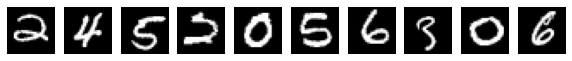

Reconstructions:


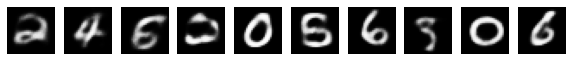

Generated Images:


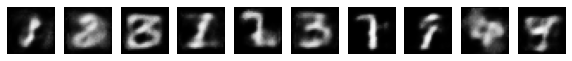

Train | Epoch: 21 [0/60000 (0%)]	Loss: 0.127454
Train | Epoch: 21 [10035200/60000 (21%)]	Loss: 0.126929
Train | Epoch: 21 [20070400/60000 (43%)]	Loss: 0.124086
Train | Epoch: 21 [30105600/60000 (64%)]	Loss: 0.128519
Train | Epoch: 21 [40140800/60000 (85%)]	Loss: 0.129222
====> Train | Epoch: 21 	 | 	 Average loss: 98.7888
====> Test  | model loss: 97.3023
Inputs:


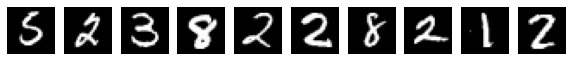

Reconstructions:


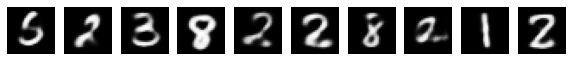

Generated Images:


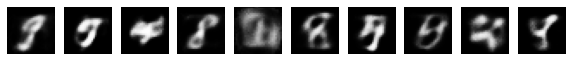

Train | Epoch: 22 [0/60000 (0%)]	Loss: 0.125043
Train | Epoch: 22 [10035200/60000 (21%)]	Loss: 0.127510
Train | Epoch: 22 [20070400/60000 (43%)]	Loss: 0.125968
Train | Epoch: 22 [30105600/60000 (64%)]	Loss: 0.123484
Train | Epoch: 22 [40140800/60000 (85%)]	Loss: 0.128158
====> Train | Epoch: 22 	 | 	 Average loss: 97.9297
====> Test  | model loss: 96.5388
Inputs:


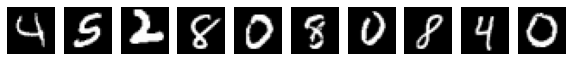

Reconstructions:


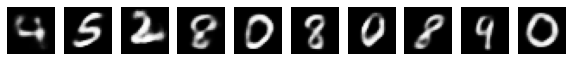

Generated Images:


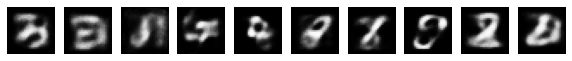

Train | Epoch: 23 [0/60000 (0%)]	Loss: 0.121710
Train | Epoch: 23 [10035200/60000 (21%)]	Loss: 0.123690
Train | Epoch: 23 [20070400/60000 (43%)]	Loss: 0.125488
Train | Epoch: 23 [30105600/60000 (64%)]	Loss: 0.123925
Train | Epoch: 23 [40140800/60000 (85%)]	Loss: 0.118801
====> Train | Epoch: 23 	 | 	 Average loss: 97.1536
====> Test  | model loss: 95.9468
Inputs:


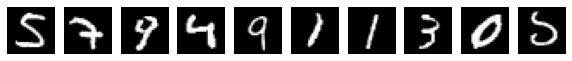

Reconstructions:


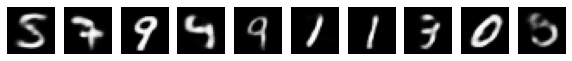

Generated Images:


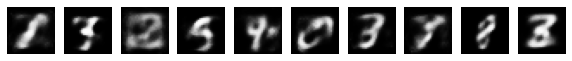

Train | Epoch: 24 [0/60000 (0%)]	Loss: 0.122415
Train | Epoch: 24 [10035200/60000 (21%)]	Loss: 0.123811
Train | Epoch: 24 [20070400/60000 (43%)]	Loss: 0.123022
Train | Epoch: 24 [30105600/60000 (64%)]	Loss: 0.123720
Train | Epoch: 24 [40140800/60000 (85%)]	Loss: 0.125587
====> Train | Epoch: 24 	 | 	 Average loss: 96.4504
====> Test  | model loss: 95.3070
Inputs:


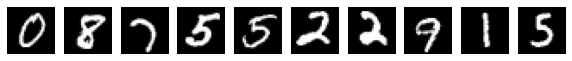

Reconstructions:


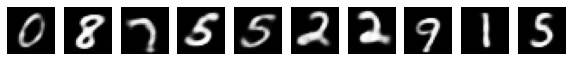

Generated Images:


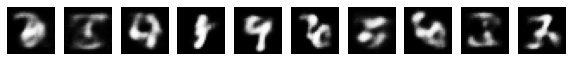

Train | Epoch: 25 [0/60000 (0%)]	Loss: 0.121758
Train | Epoch: 25 [10035200/60000 (21%)]	Loss: 0.120808
Train | Epoch: 25 [20070400/60000 (43%)]	Loss: 0.121439
Train | Epoch: 25 [30105600/60000 (64%)]	Loss: 0.123618
Train | Epoch: 25 [40140800/60000 (85%)]	Loss: 0.119545
====> Train | Epoch: 25 	 | 	 Average loss: 95.7953
====> Test  | model loss: 94.5686
Inputs:


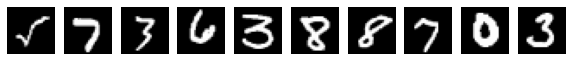

Reconstructions:


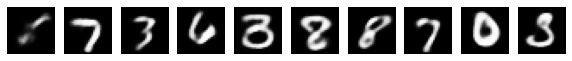

Generated Images:


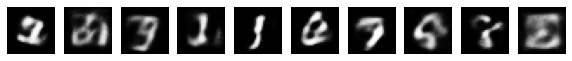

Train | Epoch: 26 [0/60000 (0%)]	Loss: 0.123007
Train | Epoch: 26 [10035200/60000 (21%)]	Loss: 0.124578
Train | Epoch: 26 [20070400/60000 (43%)]	Loss: 0.121592
Train | Epoch: 26 [30105600/60000 (64%)]	Loss: 0.120653
Train | Epoch: 26 [40140800/60000 (85%)]	Loss: 0.119631
====> Train | Epoch: 26 	 | 	 Average loss: 95.1764
====> Test  | model loss: 93.9980
Inputs:


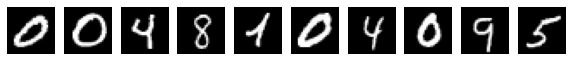

Reconstructions:


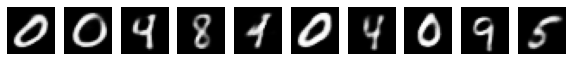

Generated Images:


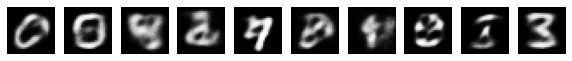

Train | Epoch: 27 [0/60000 (0%)]	Loss: 0.117409
Train | Epoch: 27 [10035200/60000 (21%)]	Loss: 0.117519
Train | Epoch: 27 [20070400/60000 (43%)]	Loss: 0.118849
Train | Epoch: 27 [30105600/60000 (64%)]	Loss: 0.118597
Train | Epoch: 27 [40140800/60000 (85%)]	Loss: 0.114098
====> Train | Epoch: 27 	 | 	 Average loss: 94.6205
====> Test  | model loss: 93.5420
Inputs:


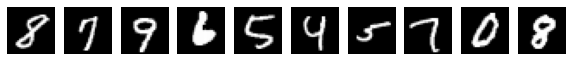

Reconstructions:


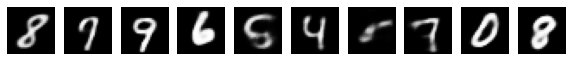

Generated Images:


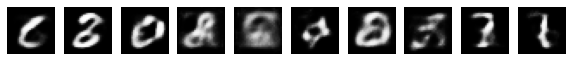

Train | Epoch: 28 [0/60000 (0%)]	Loss: 0.124098
Train | Epoch: 28 [10035200/60000 (21%)]	Loss: 0.115288
Train | Epoch: 28 [20070400/60000 (43%)]	Loss: 0.115092
Train | Epoch: 28 [30105600/60000 (64%)]	Loss: 0.119197
Train | Epoch: 28 [40140800/60000 (85%)]	Loss: 0.119122
====> Train | Epoch: 28 	 | 	 Average loss: 94.1020
====> Test  | model loss: 93.1100
Inputs:


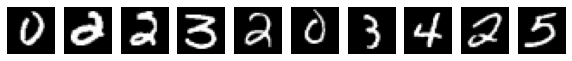

Reconstructions:


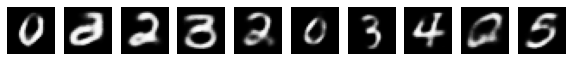

Generated Images:


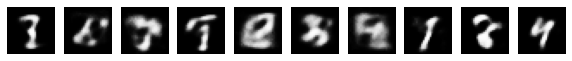

Train | Epoch: 29 [0/60000 (0%)]	Loss: 0.119370
Train | Epoch: 29 [10035200/60000 (21%)]	Loss: 0.112972
Train | Epoch: 29 [20070400/60000 (43%)]	Loss: 0.117484
Train | Epoch: 29 [30105600/60000 (64%)]	Loss: 0.121037
Train | Epoch: 29 [40140800/60000 (85%)]	Loss: 0.129360
====> Train | Epoch: 29 	 | 	 Average loss: 93.5575
====> Test  | model loss: 92.5710
Inputs:


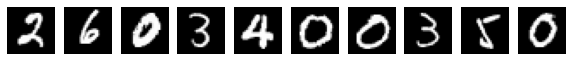

Reconstructions:


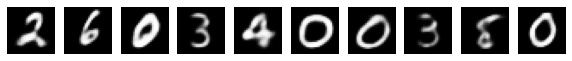

Generated Images:


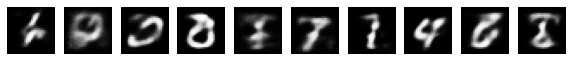

Train | Epoch: 30 [0/60000 (0%)]	Loss: 0.117595
Train | Epoch: 30 [10035200/60000 (21%)]	Loss: 0.120846
Train | Epoch: 30 [20070400/60000 (43%)]	Loss: 0.123124
Train | Epoch: 30 [30105600/60000 (64%)]	Loss: 0.122116
Train | Epoch: 30 [40140800/60000 (85%)]	Loss: 0.120354
====> Train | Epoch: 30 	 | 	 Average loss: 93.1366
====> Test  | model loss: 92.1558
Inputs:


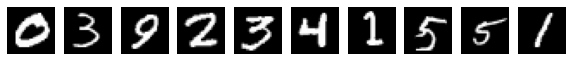

Reconstructions:


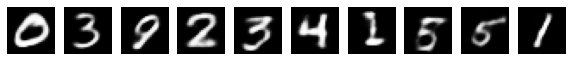

Generated Images:


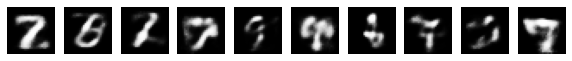

In [ ]:
n_epoch = 30
run(vae, vae.parameters(), n_epoch, train_loader, test_loader,
   end_function=show_vae)

---

In [ ]:
def check_interpolations(model, n_rows, n_cols):
    """
    Write a function which interpolates 10 images between two random mnist image
    """
    plt.rcParams['figure.figsize'] = (0.0 + n_cols, 0.0 + n_rows) # set default size of plots
    
    data_loader = train_loader
    
    for _ in range(n_rows):
        indices = torch.randint(data_loader.dataset.tensors[0].shape[0], (2,))
        img_1 = data_loader.dataset.tensors[0][indices][:1].flatten(start_dim=1)
        img_2 = data_loader.dataset.tensors[0][indices][1:].flatten(start_dim=1)
        
        ########################## TODO ##########################
        # Output `n_cols` images.
        # First one should be img_1. Last one should by img_2
        # Let z_1 and z_2 be latent tensors of img_1 and img_2
        # Interpolate (n_cols - 2) tensors between z_1 and z_2
        # Intermediate images must be the result of applying decoder on these (n_cols - 2) tensors
        d1 = {'X': img_1.to('cuda')}
        z1 = vae(d1)['z']

        d2 = {'X': img_2.to('cuda')}
        z2 = vae(d2)['z']

        my_list = []

        my_list.append(img_1)
        
        for w in range(1, n_cols):
          intr = torch.lerp(z1, z2, w/n_cols)
          recon_img = vae.decoder(intr).to('cpu')
          my_list.append(recon_img)

        my_list.append(img_2)

        output = torch.stack(my_list).view(len(my_list),28,28).detach()
        
        ######################## END TODO ########################
        
        show(output)

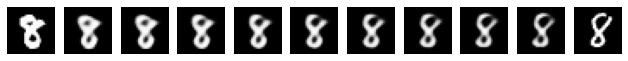

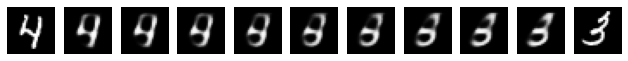

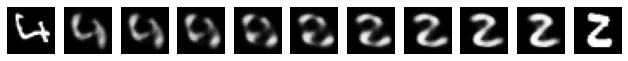

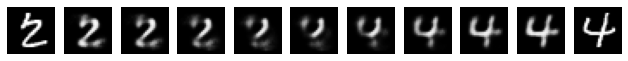

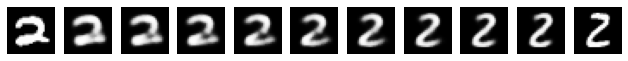

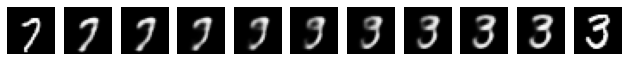

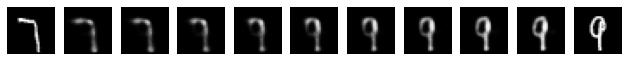

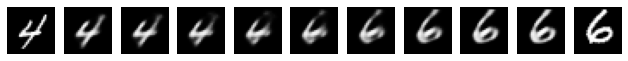

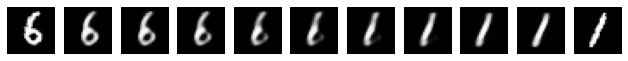

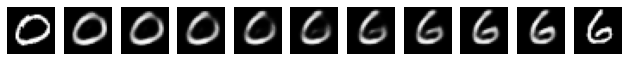

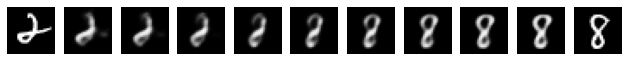

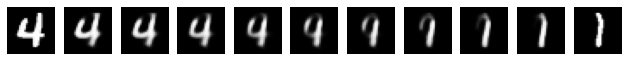

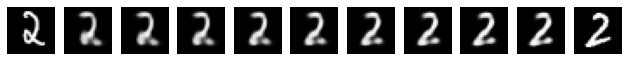

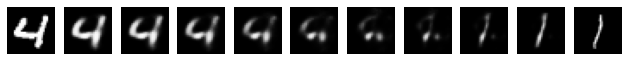

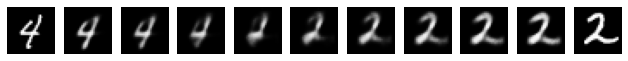

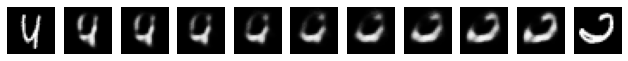

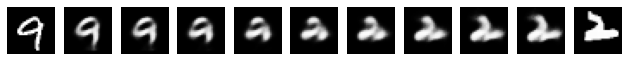

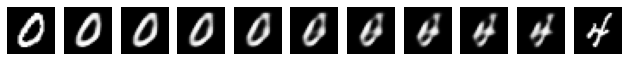

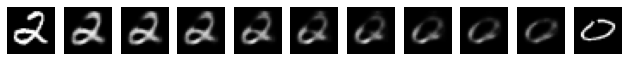

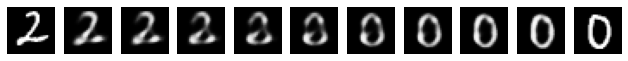

In [ ]:
check_interpolations(vae, 20, 10)